# Analisis Explotario y Ingenieria de Caracteristicas
### Nombre: Eduardo Arce, Esteban Cordova

### Importaci√≥n de modulos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
import joblib


# Configuraci√≥n est√©tica
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
print("Modulos importados")

/home/eduardo/PycharmProjects/Calculo_Entropia/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-21 21:25:40.364505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-21 21:25:40.364547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-21 21:25:40.365631: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-21 21:25:40.371850: I tensorflow/core/platform/cpu_feature_guard.cc:18

Modulos importados


 ## 1. Carga inicial del dataset
### Vistazo inicial al mismo

In [2]:
# Cargar el dataset
df = pd.read_csv("test_set_1.csv")

# Vista inicial
df.head()

userId  movieId  rating   timestamp
0   66954      780     3.0   850944100
1    9877      566     3.0   945497442
2   38348     1086     4.0   999975049
3  177202     1020     4.0   948169041
4  140400   275079     3.5  1653782463

## 2. Informaci√≥n general del DataFrame

Obtenemos una descripci√≥n b√°sica de la estructura del dataset, incluyendo:

- El n√∫mero total de registros (filas)
- Las columnas presentes en el dataset
- El tipo de dato de cada columna (`int64`, `float64`, `object`, etc.)
- La cantidad de valores no nulos por columna

Esta informaci√≥n es √∫til para detectar la presencia de valores faltantes, identificar columnas mal tipadas (por ejemplo fechas como `object`), y verificar que la estructura general sea coherente antes de proceder con el an√°lisis.


In [3]:
# Informaci√≥n general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333368 entries, 0 to 5333367
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 162.8 MB


## 3. Estad√≠sticas descriptivas

Obtenemos estad√≠sticas resumidas de las columnas num√©ricas, como la media, mediana, m√≠nimo, m√°ximo y desviaci√≥n est√°ndar. Esto ayuda a entender la dispersi√≥n, sesgo y rangos t√≠picos de los datos num√©ricos, especialmente del `rating`.


In [4]:
# Estad√≠sticas descriptivas
df.describe()

userId       movieId        rating     timestamp
count  5.333368e+06  5.333368e+06  5.333368e+06  5.333368e+06
mean   1.003232e+05  2.932297e+04  3.540315e+00  1.275147e+09
std    5.795290e+04  5.096274e+04  1.059116e+00  2.561771e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  8.228736e+08
25%    5.014500e+04  1.232000e+03  3.000000e+00  1.050908e+09
50%    1.003430e+05  3.461000e+03  3.500000e+00  1.272265e+09
75%    1.505050e+05  4.419900e+04  4.000000e+00  1.503066e+09
max    2.009480e+05  2.927550e+05  5.000000e+00  1.697164e+09

## 4. M√©tricas generales del dataset

Calculamos algunas m√©tricas clave para tener una visi√≥n general del conjunto:

- Total de usuarios y pel√≠culas √∫nicos, lo que da una idea del tama√±o del sistema.
- Estad√≠sticas b√°sicas de los ratings (m√≠nimo, m√°ximo y promedio).
- Rango temporal de las calificaciones, √∫til para detectar si hay sesgos de √©poca o cambios en el comportamiento del usuario a lo largo del tiempo.


In [5]:
# Estadisticas varias
# N√∫mero de usuarios y pel√≠culas √∫nicos
num_users = df['userId'].nunique()
num_movies = df['movieId'].nunique()

# Estad√≠sticas de ratings
rating_min = df['rating'].min()
rating_max = df['rating'].max()
rating_mean = df['rating'].mean()

# Rango de tiempo (de timestamp a fecha)
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
date_min = df['date'].min()
date_max = df['date'].max()

# Mostrar resultados
print(f'Usuarios √∫nicos: {num_users:,}')
print(f'Pel√≠culas √∫nicas: {num_movies:,}')
print(f'Rating m√≠nimo: {rating_min}')
print(f'Rating m√°ximo: {rating_max}')
print(f'Rating promedio: {rating_mean:.2f}')
print(f'Rango temporal: {date_min.date()} ‚Üí {date_max.date()}')

Usuarios √∫nicos: 200,384
Pel√≠culas √∫nicas: 50,879
Rating m√≠nimo: 0.5
Rating m√°ximo: 5.0
Rating promedio: 3.54
Rango temporal: 1996-01-29 ‚Üí 2023-10-13


# Visualizaci√≥n

## 5. Distribuci√≥n de calificaciones

Visualizamos la distribuci√≥n de las calificaciones para identificar posibles sesgos. Es com√∫n en datasets como MovieLens observar una concentraci√≥n en valores altos (por ejemplo, 4.0 o 5.0), lo cual puede influir en los modelos de recomendaci√≥n.

El uso de KDE (`kde=True`) permite suavizar la curva y observar mejor la forma general de la distribuci√≥n.


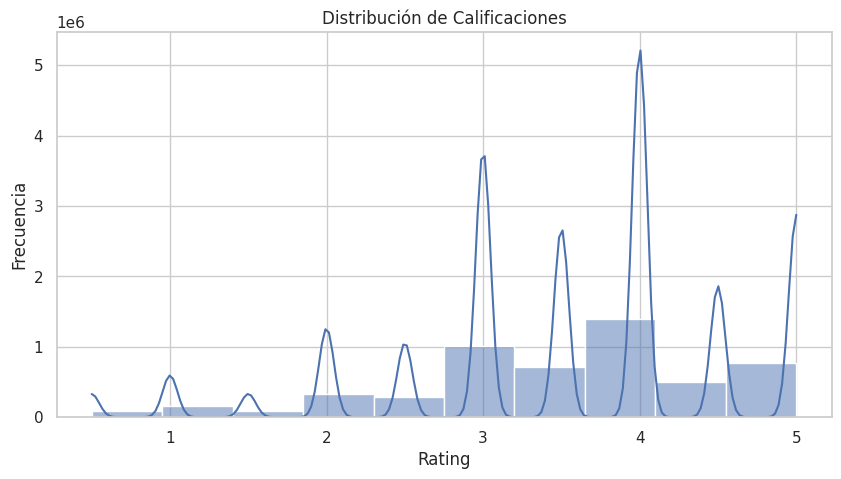

In [6]:
# Distribuci√≥n de calificaciones
sns.histplot(df['rating'], bins=10, kde=True)
plt.title("Distribuci√≥n de Calificaciones")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.show()

## 6. Actividad de los usuarios

Se analiza cu√°ntas calificaciones ha hecho cada usuario. El boxplot permite identificar la dispersi√≥n de esta actividad y detectar usuarios muy activos (outliers) que califican muchas m√°s pel√≠culas que el promedio.

Esto es √∫til para entender la densidad del dataset y evaluar si existen usuarios que podr√≠an influir desproporcionadamente en los modelos.


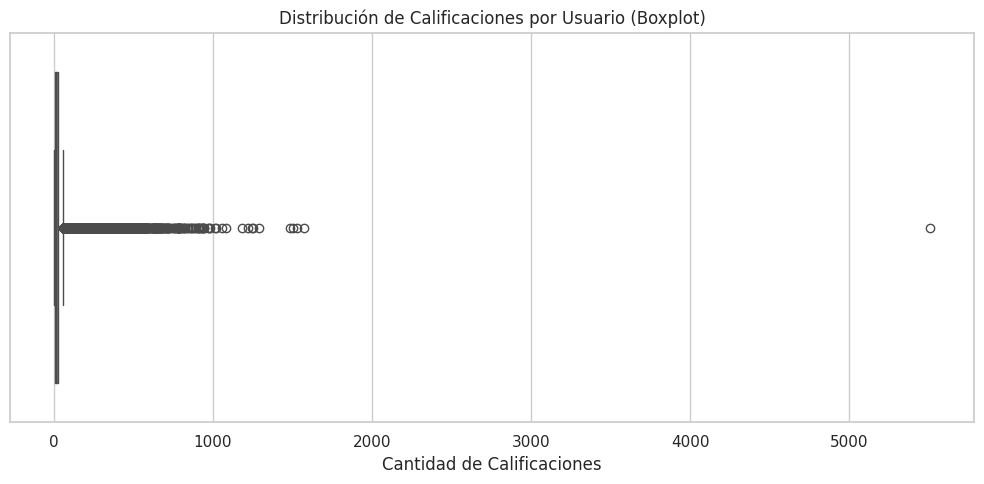

In [7]:
user_counts = df['userId'].value_counts()
sns.boxplot(x=user_counts)
plt.title("Distribuci√≥n de Calificaciones por Usuario (Boxplot)")
plt.xlabel("Cantidad de Calificaciones")
plt.tight_layout()
plt.show()


### Observaciones del gr√°fico

El boxplot revela una fuerte asimetr√≠a en la cantidad de calificaciones por usuario. La gran mayor√≠a califica menos de 200 pel√≠culas, mientras que unos pocos usuarios extremos llegan a superar las 5000. Este patr√≥n de largo extremo es caracter√≠stico de datasets de comportamiento humano en sistemas de recomendaci√≥n, y es importante considerarlo al entrenar modelos, ya que estos usuarios outlier pueden influir de forma desproporcionada.


## 7. Distribuci√≥n de usuarios con baja actividad

Se analiza en detalle el subconjunto de usuarios que realizaron 200 o menos calificaciones. Esta visualizaci√≥n permite observar con mayor claridad la distribuci√≥n en la "cola corta" del boxplot anterior, donde se concentra la mayor√≠a de usuarios.

Este tipo de an√°lisis ayuda a identificar patrones en usuarios poco activos, quienes suelen representar el mayor volumen en sistemas reales y pueden afectar la calidad de las recomendaciones personalizadas.


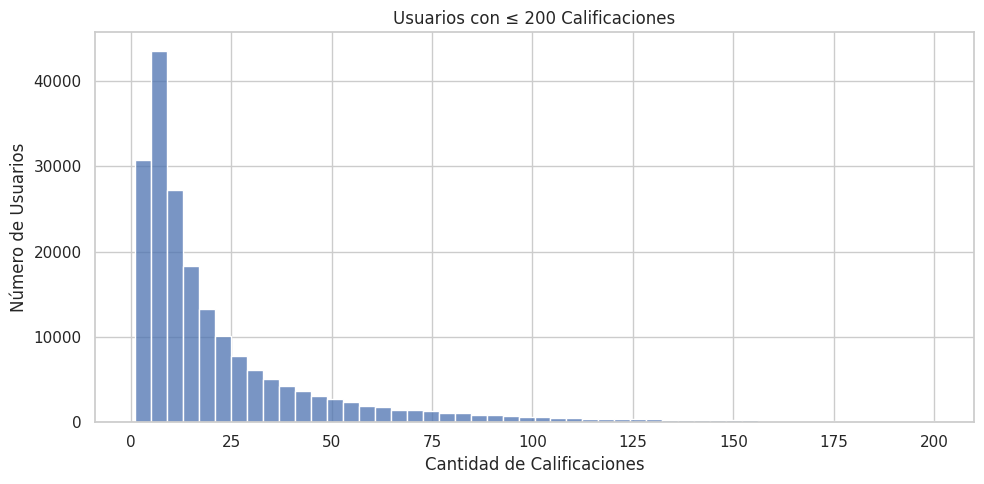

In [ ]:
user_counts_trimmed = user_counts[user_counts <= 200]
sns.histplot(user_counts_trimmed, bins=50, kde=False)
plt.title("Usuarios con ‚â§ 200 Calificaciones")
plt.xlabel("Cantidad de Calificaciones")
plt.ylabel("N√∫mero de Usuarios")
plt.tight_layout()
plt.show()


## 8. Actividad por pel√≠cula

El boxplot muestra la cantidad de calificaciones recibidas por cada pel√≠cula. Al igual que en el caso de los usuarios, observamos una distribuci√≥n asim√©trica, donde pocas pel√≠culas concentran una gran cantidad de ratings, mientras que la mayor√≠a reciben solo unos pocos.

Esto refleja un fen√≥meno t√≠pico en sistemas de recomendaci√≥n: una minor√≠a de √≠tems son muy populares, mientras que muchos otros tienen baja exposici√≥n (problema de "larga cola").


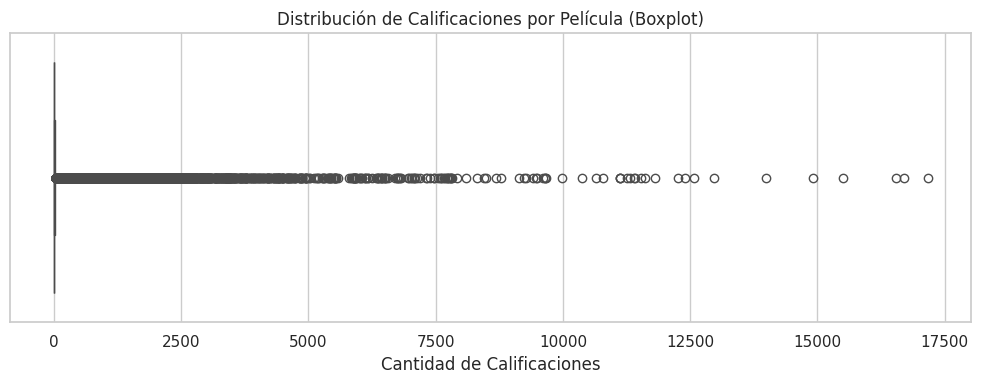

In [9]:
movie_counts = df['movieId'].value_counts()
plt.figure(figsize=(10, 4))
sns.boxplot(x=movie_counts)
plt.title("Distribuci√≥n de Calificaciones por Pel√≠cula (Boxplot)")
plt.xlabel("Cantidad de Calificaciones")
plt.tight_layout()
plt.show()

## 9. Pel√≠culas con baja cantidad de calificaciones

Se analiza el subconjunto de pel√≠culas que han recibido 100 o menos calificaciones. Este tipo de visualizaci√≥n permite enfocarse en la mayor√≠a silenciosa del cat√°logo: pel√≠culas que apenas han sido vistas o valoradas.

Es importante tener en cuenta esta baja interacci√≥n al momento de entrenar modelos, ya que estas pel√≠culas suelen tener datos insuficientes para generar buenas recomendaciones (problema de *cold start*).


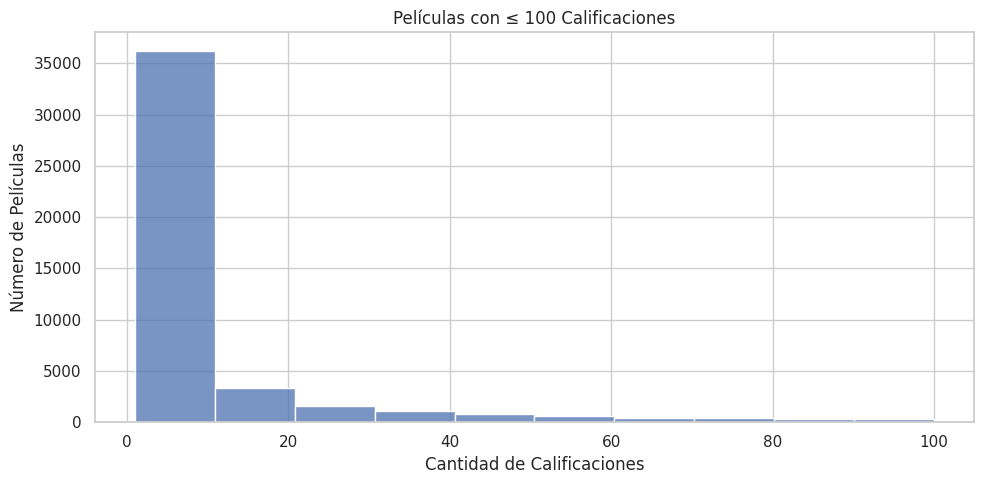

In [10]:
movie_counts_trimmed = movie_counts[movie_counts <= 100]

plt.figure(figsize=(10, 5))
sns.histplot(movie_counts_trimmed, bins=10, kde=False)
plt.title("Pel√≠culas con ‚â§ 100 Calificaciones")
plt.xlabel("Cantidad de Calificaciones")
plt.ylabel("N√∫mero de Pel√≠culas")
plt.tight_layout()
plt.show()

## 10. Evoluci√≥n temporal de las calificaciones

Se transforma el timestamp a formato de fecha para analizar c√≥mo ha evolucionado la cantidad de calificaciones a lo largo del tiempo. 

La distribuci√≥n por a√±o permite identificar posibles aumentos en la actividad de los usuarios, cambios en el uso de la plataforma o periodos an√≥malos que podr√≠an requerir un tratamiento especial.


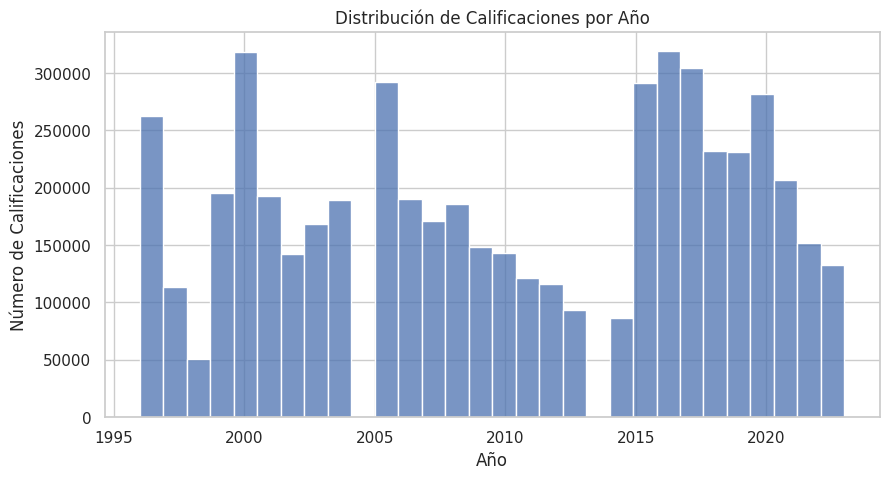

In [11]:
# Conversi√≥n de timestamp a fecha
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
df['year'] = df['date'].dt.year

# Evoluci√≥n de calificaciones por a√±o
sns.histplot(df['year'], bins=30, kde=False)
plt.title("Distribuci√≥n de Calificaciones por A√±o")
plt.xlabel("A√±o")
plt.ylabel("N√∫mero de Calificaciones")
plt.show()

### 11. Usuarios con comportamiento extremo constante

Se identifican usuarios que califican exclusivamente con 5.0 o con 0.5. Este tipo de comportamiento sugiere perfiles con sesgo extremo, posiblemente poco √∫tiles para modelos predictivos ya que no ofrecen variabilidad en sus preferencias.


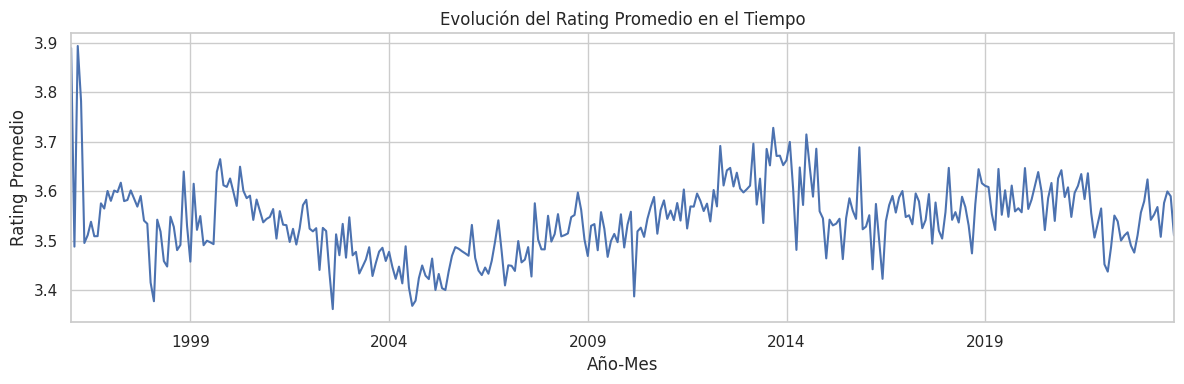

In [31]:
df['year_month'] = df['date'].dt.to_period('M')
monthly_avg = df.groupby('year_month')['rating'].mean()

monthly_avg.plot(figsize=(12, 4))
plt.title("Evoluci√≥n del Rating Promedio en el Tiempo")
plt.xlabel("A√±o-Mes")
plt.ylabel("Rating Promedio")
plt.grid(True)
plt.tight_layout()
plt.show()


### 12. Usuarios extremadamente activos (Z-score)

Aplicando Z-score al n√∫mero de calificaciones por usuario, se detectan aquellos usuarios cuyo comportamiento es estad√≠sticamente extremo. Este an√°lisis cuantitativo complementa los boxplots anteriores, identificando outliers en t√©rminos de volumen de interacci√≥n.


In [37]:
from scipy.stats import zscore

user_rating_counts = df['userId'].value_counts()
z_scores = zscore(user_rating_counts)

outlier_users_z = user_rating_counts[z_scores > 3]  # Z > 3 como umbral com√∫n

print(f"Usuarios extremadamente activos (Z-score > 3): {len(outlier_users_z)}")


Usuarios extremadamente activos (Z-score > 3): 3541


## 13. Dispersi√≥n de interacciones (Sparsity)

Se visualiza la matriz de interacciones entre usuarios y pel√≠culas para evidenciar el grado de dispersi√≥n de los datos.

Como es com√∫n en sistemas de recomendaci√≥n, la matriz es extremadamente dispersa: la mayor√≠a de los usuarios han calificado solo una peque√±a fracci√≥n del cat√°logo. Esto refuerza la necesidad de usar t√©cnicas robustas ante datos escasos (como filtrado colaborativo, modelos basados en embeddings, etc.).


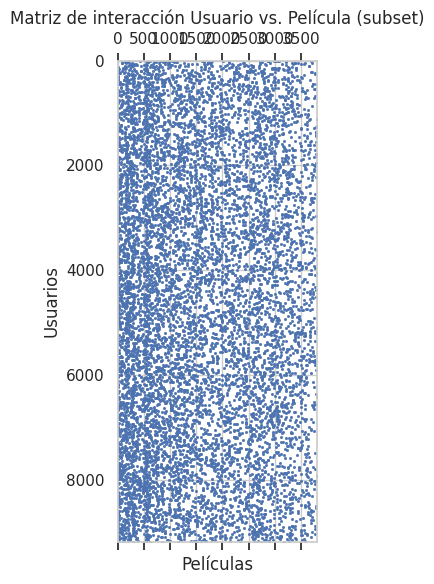

In [32]:
sample = df.sample(10000)  # Subset para eficiencia
pivot = sample.pivot(index='userId', columns='movieId', values='rating').fillna(0)

plt.figure(figsize=(10, 6))
plt.spy(pivot, markersize=1)
plt.title("Matriz de interacci√≥n Usuario vs. Pel√≠cula (subset)")
plt.xlabel("Pel√≠culas")
plt.ylabel("Usuarios")
plt.tight_layout()
plt.show()


# Analisis estadistico

## 14. An√°lisis estad√≠stico general

Se resumen las estad√≠sticas descriptivas de las calificaciones (`rating`), como el promedio, los valores m√≠nimo y m√°ximo, as√≠ como la desviaci√≥n est√°ndar, que indica el grado de variabilidad en las opiniones de los usuarios.

Tambi√©n se identifican:
- El n√∫mero total de usuarios y pel√≠culas √∫nicos.
- La pel√≠cula con m√°s y menos calificaciones (√≠tems extremos en popularidad).
- El usuario m√°s activo (con mayor n√∫mero de ratings) y el menos activo.

Estos datos permiten tener una visi√≥n global del comportamiento de interacci√≥n dentro del dataset.


In [12]:
# Estad√≠sticas generales del rating
rating_stats = df['rating'].describe()
print("Estad√≠sticas de Ratings:")
print(rating_stats)

# Desviaci√≥n est√°ndar
std_rating = df['rating'].std()
print("\nDesviaci√≥n est√°ndar del rating:", round(std_rating, 4))

# N√∫mero total de usuarios √∫nicos
num_users = df['userId'].nunique()
print("\nTotal de usuarios √∫nicos:", num_users)

# N√∫mero total de √≠tems √∫nicos
num_items = df['movieId'].nunique()
print("Total de pel√≠culas √∫nicas:", num_items)

# √çtem m√°s consumido
top_item = df['movieId'].value_counts().idxmax()
top_item_count = df['movieId'].value_counts().max()
print("\nPel√≠cula m√°s calificada:", top_item, "con", top_item_count, "calificaciones")

# √çtem menos consumido
bottom_item = df['movieId'].value_counts().idxmin()
bottom_item_count = df['movieId'].value_counts().min()
print("Pel√≠cula menos calificada:", bottom_item, "con", bottom_item_count, "calificaci√≥n")

# Usuario m√°s activo
top_user = df['userId'].value_counts().idxmax()
top_user_count = df['userId'].value_counts().max()
print("\nUsuario m√°s activo:", top_user, "con", top_user_count, "ratings")

# Usuario menos activo
bottom_user = df['userId'].value_counts().idxmin()
bottom_user_count = df['userId'].value_counts().min()
print("Usuario menos activo:", bottom_user, "con", bottom_user_count, "rating")


Estad√≠sticas de Ratings:
count    5.333368e+06
mean     3.540315e+00
std      1.059116e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Desviaci√≥n est√°ndar del rating: 1.0591

Total de usuarios √∫nicos: 200384
Total de pel√≠culas √∫nicas: 50879

Pel√≠cula m√°s calificada: 318 con 17162 calificaciones
Pel√≠cula menos calificada: 189869 con 1 calificaci√≥n

Usuario m√°s activo: 175325 con 5507 ratings
Usuario menos activo: 82023 con 1 rating


## 15. Correlaci√≥n entre variables num√©ricas

Aunque el dataset cuenta con pocas variables num√©ricas, se explora la relaci√≥n entre `rating` y `timestamp` (momento de la calificaci√≥n).

Este an√°lisis permite detectar si existe alguna relaci√≥n temporal en la forma de calificar, como una tendencia a puntuar m√°s bajo o m√°s alto en ciertas √©pocas. La ausencia de correlaci√≥n tambi√©n puede ser un hallazgo relevante.


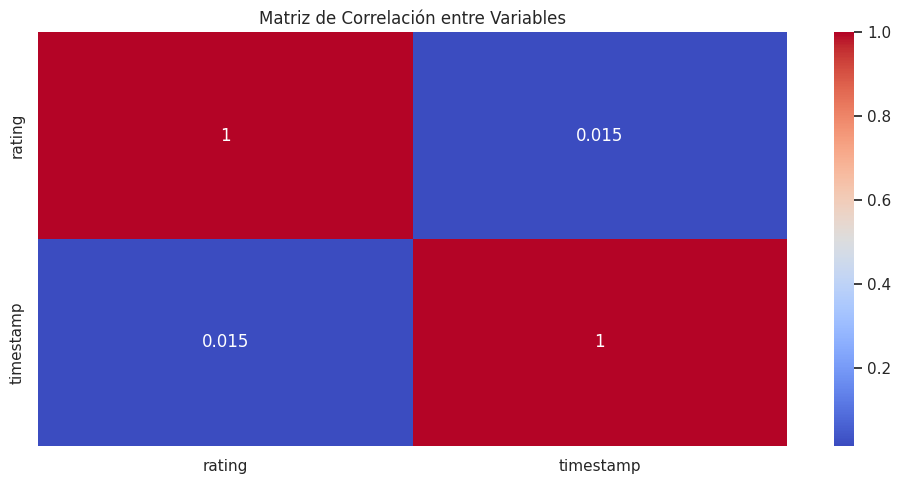

In [33]:
corr_matrix = df[['rating', 'timestamp']].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlaci√≥n entre Variables")
plt.tight_layout()
plt.show()


# Analisis de outliers

## 16. Detecci√≥n de outliers en comportamiento de usuarios

Se identifican usuarios que han otorgado siempre la misma calificaci√≥n. Este tipo de comportamiento puede indicar perfiles con sesgo extremo o datos no fiables (por ejemplo, bots, usuarios poco activos o con uso at√≠pico del sistema).

Adem√°s, se analiza qu√© valor espec√≠fico usaron estos usuarios √∫nicos: muchos de ellos tienden a calificar exclusivamente con 5.0 (valor m√°ximo), lo cual podr√≠a sesgar el promedio general si no se controla adecuadamente.

Este an√°lisis permite anticipar la necesidad de filtrar, ponderar o tratar de forma especial estos casos en etapas posteriores del modelado.


In [13]:
# Usuarios que solo usan una calificaci√≥n
user_rating_unique_counts = df.groupby('userId')['rating'].nunique()

# Usuarios que solo votan con 1 calificaci√≥n √∫nica (posible outlier)
outlier_users = user_rating_unique_counts[user_rating_unique_counts == 1]
print(f"Usuarios que solo usan un mismo valor de rating: {len(outlier_users)}")

# ¬øQu√© calificaci√≥n espec√≠fica usaron?
outlier_details = df[df['userId'].isin(outlier_users.index)].groupby('userId')['rating'].first().value_counts()
print("Distribuci√≥n de rating √∫nico entre los outliers:")
print(outlier_details)

# Usuarios que solo dan calificaciones altas o bajas (por ejemplo, solo 5.0 o solo 0.5)
only_high = outlier_details.get(5.0, 0)
only_low = outlier_details.get(0.5, 0)


Usuarios que solo usan un mismo valor de rating: 7104
Distribuci√≥n de rating √∫nico entre los outliers:
rating
5.0    2809
4.0    1750
3.0    1316
4.5     388
3.5     295
2.0     174
1.0     113
2.5     105
0.5     105
1.5      49
Name: count, dtype: int64


### 17. Outliers en la distribuci√≥n general de ratings

Se visualiza el boxplot de todos los ratings. Aunque el rango est√° acotado entre 0.5 y 5.0, este gr√°fico permite observar la distribuci√≥n general, acumulaciones en los extremos y confirmar si existen valores at√≠picos concentrados (como una sobrerrepresentaci√≥n del 5.0).


In [36]:
# Usuarios que solo usan ratings m√°ximos
only_5_users = df.groupby('userId')['rating'].apply(lambda x: x.nunique() == 1 and x.iloc[0] == 5.0)
only_0_5_users = df.groupby('userId')['rating'].apply(lambda x: x.nunique() == 1 and x.iloc[0] == 0.5)

print(f"Usuarios que solo dan 5.0: {only_5_users.sum()}")
print(f"Usuarios que solo dan 0.5: {only_0_5_users.sum()}")


Usuarios que solo dan 5.0: 2809
Usuarios que solo dan 0.5: 105


# Clustering

## 18. Segmentaci√≥n de usuarios (K-means Clustering)

Se aplica un modelo de clustering no supervisado (K-means) para identificar grupos de usuarios seg√∫n su comportamiento general: promedio de calificaciones y cantidad total de interacciones.

Esto permite clasificar a los usuarios en segmentos como:
- Cr√≠ticos (bajo promedio de rating)
- Generosos (alto promedio)
- Moderados
- Activos vs. pasivos (seg√∫n n√∫mero de calificaciones)

Esta segmentaci√≥n puede ser √∫til para personalizar estrategias de recomendaci√≥n o analizar diferencias de comportamiento.


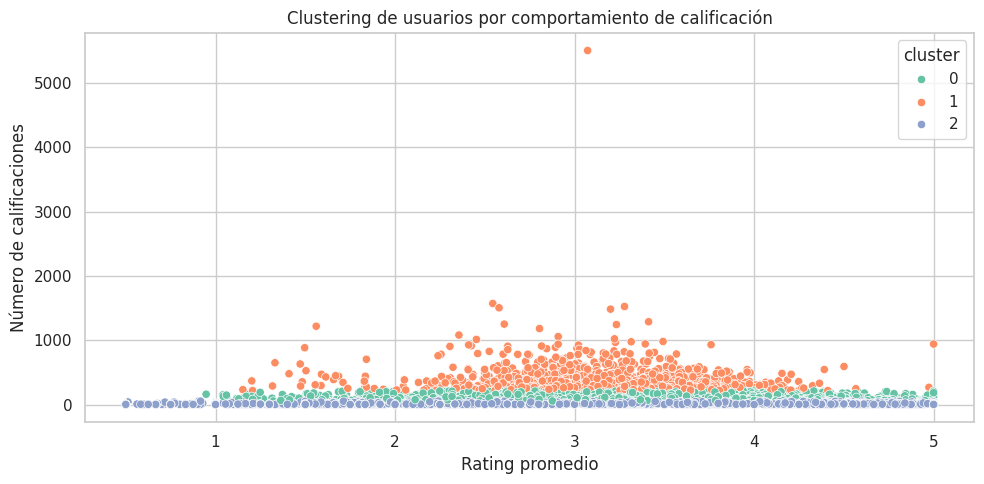

In [34]:
from sklearn.cluster import KMeans

user_profiles = df.groupby('userId')['rating'].agg(['mean', 'count']).reset_index()
user_profiles.columns = ['userId', 'avg_rating', 'num_ratings']

kmeans = KMeans(n_clusters=3, random_state=0)
user_profiles['cluster'] = kmeans.fit_predict(user_profiles[['avg_rating', 'num_ratings']])

sns.scatterplot(data=user_profiles, x='avg_rating', y='num_ratings', hue='cluster', palette='Set2')
plt.title("Clustering de usuarios por comportamiento de calificaci√≥n")
plt.xlabel("Rating promedio")
plt.ylabel("N√∫mero de calificaciones")
plt.grid(True)
plt.tight_layout()
plt.show()


## 19. Conclusiones del An√°lisis Exploratorio

- La mayor√≠a de los usuarios y pel√≠culas tienen una baja actividad, lo cual sugiere una distribuci√≥n de tipo "larga cola".
- Se identificaron usuarios at√≠picos que califican siempre con el mismo valor, especialmente con 5.0, lo que puede introducir sesgos.
- El an√°lisis temporal mostr√≥ una evoluci√≥n creciente en la actividad de calificaci√≥n, con variaciones en la media de los ratings a lo largo del tiempo.
- El dataset presenta alta dispersi√≥n en la matriz de interacci√≥n usuario-pel√≠cula, lo cual podr√≠a requerir t√©cnicas espec√≠ficas como filtrado colaborativo basado en vecinos o modelos con embeddings.
- Estas observaciones son fundamentales para dise√±ar modelos de recomendaci√≥n m√°s robustos, considerando tanto los comportamientos mayoritarios como los extremos.


# Experimentos

In [14]:
# üîπ 2. Convertir timestamp
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

In [15]:
# üîπ 3. Codificar temporada, fin de semana y feriado
def get_season(month):
    if month in [12, 1, 2]:
        return 'invierno'
    elif month in [3, 4, 5]:
        return 'primavera'
    elif month in [6, 7, 8]:
        return 'verano'
    else:
        return 'oto√±o'

df['season'] = df['month'].apply(get_season)

In [16]:
df['is_weekend'] = df['weekday'].isin([5, 6])


In [17]:
ecu_holidays = holidays.Ecuador(years=range(df['year'].min(), df['year'].max() + 1))
df['is_holiday'] = df['date'].isin(ecu_holidays)
print(df[['season', 'is_weekend', 'is_holiday']].describe(include='all'))

/tmp/ipykernel_36010/1763053412.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['date'].isin(ecu_holidays)


          season is_weekend is_holiday
count    5333368    5333368    5333368
unique         4          2          2
top     invierno      False      False
freq     1360697    3737820    5333366


In [18]:
# üîπ 4. Codificaci√≥n booleana y categ√≥rica
df['season_encoded'] = df['season'].map({'invierno': 0, 'primavera': 1, 'verano': 2, 'oto√±o': 3})
df['is_weekend'] = df['is_weekend'].astype(int)
df['is_holiday'] = df['is_holiday'].astype(int)


In [19]:
# üîπ 5. Calcular rating_previous
df = df.sort_values(['userId', 'timestamp'])

In [20]:
# üîπ Asegurar que week_of_year sea int para el merge
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)

# üîπ Calcular consumo semanal
consumo = df.groupby(['userId', 'week_of_year']).size().reset_index(name='consumo_semanal_usuario')
df = pd.merge(df, consumo, on=['userId', 'week_of_year'], how='left')



In [21]:
# üîπ 7. Ingenier√≠a UMAP
temporal_features = ['year', 'month', 'weekday', 'season_encoded', 'is_weekend', 'is_holiday']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[temporal_features])
joblib.dump(scaler, "scaler_temporal2.pkl")  # ‚úÖ ahora s√≠ lo guardas correctamente

['scaler_temporal2.pkl']

In [22]:
# UMAP sobre muestra aleatoria
sample_size = 100_000
sample_idx = np.random.choice(len(X_scaled), size=sample_size, replace=False)
X_sample = X_scaled[sample_idx]

In [23]:
reducer = umap.UMAP(n_components=3, random_state=42, init='random', n_neighbors=15, min_dist=0.1)
reducer.fit(X_sample)
X_umap_full = reducer.transform(X_scaled)
joblib.dump(reducer, 'umap_model2.pkl')


/home/eduardo/PycharmProjects/Calculo_Entropia/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/eduardo/PycharmProjects/Calculo_Entropia/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/eduardo/PycharmProjects/Calculo_Entropia/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/eduardo/PycharmProjects/Calculo_Entropia/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  

['umap_model2.pkl']

In [24]:
# Agregar latentes al dataframe
df[['temporal_1', 'temporal_2', 'temporal_3']] = X_umap_full

# üîπ 8. Seleccionar columnas finales para la RNN
columns_to_keep = [
    'userId', 'movieId',
    'temporal_1', 'temporal_2', 'temporal_3',
    'rating', 'timestamp',
    'is_weekend', 'season_encoded', 'is_holiday',
    'year', 'month', 'weekday',
    'consumo_semanal_usuario'
]


In [25]:
df_rnn_final = df[columns_to_keep]

# üîπ 9. Guardar dataset final
df_rnn_final.to_csv("dataset_final_2.csv", index=False)
print("‚úÖ Dataset RNN FINAL generado exitosamente.")

‚úÖ Dataset RNN FINAL generado exitosamente.


In [26]:
import pandas as pd

# Ruta del archivo CSV
csv_path = "dataset_final_2.csv"

# Cargar el DataFrame
df_rnn_final = pd.read_csv(csv_path)

# Mostrar primeras filas para verificar
print("Datos cargados:")
print(df.head())

Datos cargados:
   userId  movieId  rating  timestamp                date  year  month  \
0       1      541     5.0  943227521 1999-11-21 23:38:41  1999     11   
1       1      166     5.0  943228442 1999-11-21 23:54:02  1999     11   
2       1     1784     1.0  943228545 1999-11-21 23:55:45  1999     11   
3       1     1944     2.0  943231120 1999-11-22 00:38:40  1999     11   
4       1     1208     5.0  943231192 1999-11-22 00:39:52  1999     11   

   weekday season  is_weekend  is_holiday  season_encoded  week_of_year  \
0        6  oto√±o           1           0               3            46   
1        6  oto√±o           1           0               3            46   
2        6  oto√±o           1           0               3            46   
3        0  oto√±o           0           0               3            47   
4        0  oto√±o           0           0               3            47   

   consumo_semanal_usuario  temporal_1  temporal_2  temporal_3  
0                 